### PyTorch NN Studies Notebook I - Breast Cancer Classification

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import time
import random
from IPython.display import clear_output

In [19]:
import torch
print(torch.__version__)

1.9.1+cpu


### Loading Datasets:

In [13]:
data_base_path = 'C:/Users/Mafeus/Desktop/pyTorch course/Bases/Bases/'

In [21]:
input_data  = pd.read_csv(data_base_path + 'entradas_breast.csv')
output_data = pd.read_csv(data_base_path + 'saidas_breast.csv')

input_data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,706.771388,19.289649,91.969033,654.889104,4.304801,4.835984,7.489124,2.366459,16.965766,0.851112,...,315.194921,25.677223,107.261213,880.583128,10.633281,25.259112,26.723742,8.745685,30.367174,1.964313
std,2430.243368,4.301036,24.298981,351.914129,21.074558,26.827478,35.618994,16.155145,53.846023,7.103493,...,1655.459336,6.146258,33.602542,569.356993,37.236433,96.473015,114.204035,39.465975,90.748044,14.464355
min,7.760000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.116700,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,12.210000,16.170000,75.170000,420.300000,0.086410,0.065260,0.029580,0.020310,0.163400,0.057800,...,13.180000,21.080000,84.110000,515.300000,0.117800,0.150700,0.116800,0.064990,0.254900,0.071460
50%,13.850000,18.840000,86.240000,551.100000,0.095940,0.094620,0.063870,0.033900,0.181400,0.061660,...,15.150000,25.410000,97.660000,686.500000,0.133800,0.227900,0.249200,0.101500,0.288400,0.080060
75%,17.680000,21.800000,104.100000,782.700000,0.106100,0.132500,0.142500,0.077260,0.203600,0.066400,...,19.850000,29.720000,125.400000,1084.000000,0.150000,0.384200,0.431600,0.170800,0.331800,0.092110
max,9904.000000,39.280000,188.500000,2501.000000,123.000000,277.000000,313.000000,162.000000,304.000000,78.000000,...,9981.000000,49.540000,251.200000,4254.000000,185.000000,1058.000000,1252.000000,291.000000,544.000000,173.000000


In [22]:
output_data.describe()

,0
count,569.000000
mean,0.627417
std,0.483918
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


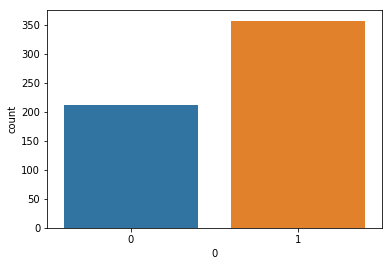

In [23]:
sns.countplot(output_data['0']);

### Data Preparation:

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size = 0.25)

In [49]:
print('X_train Shape:', X_train.shape, 'Y_train Shape:', Y_train.shape)
print('X_test Shape:', X_test.shape, 'Y_test Shape:', Y_test.shape)

X_train Shape: (426, 30) Y_train Shape: (426, 1)
X_test Shape: (143, 30) Y_test Shape: (143, 1)


In [50]:
import torch.nn as nn
np.random.seed(123)
torch.manual_seed(123)

In [51]:
X_train_torch = torch.tensor(np.array(X_train), dtype=torch.float)
Y_train_torch = torch.tensor(np.array(Y_train), dtype=torch.float)

In [52]:
dataset = torch.utils.data.TensorDataset(X_train_torch, Y_train_torch)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

### NN Model Build Up

In [78]:
# 30 -> 16 -> 16 -> 1
# (input + output) / 2 = (30 + 1) / 2 = 16

classifier = nn.Sequential(nn.Linear(in_features=30, out_features=16),
                           nn.ReLU(),
                           nn.Linear(16, 16),
                           nn.ReLU(),
                           nn.Linear(16, 1),
                           nn.Sigmoid()
                           )

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=0.0001)
epochs = 100

print(classifier.parameters)

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)>


### Model Training:

In [79]:
def torch_model_train(nn, optimizer, criterion, train_loader, epochs):
    
    for epoch in range(epochs):

        running_loss = 0.
        
        if (epoch % 10 == 0):
            clear_output(wait=True)

        for data in train_loader:
            
            inputs, labels = data
            optimizer.zero_grad()

            outputs = nn(inputs) # classificador.forward(inputs)
            loss = criterion(outputs, labels)
                        
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print('Epoch %3d: Loss: %.5f' % (epoch+1, running_loss/len(train_loader)))

In [80]:
torch_model_train(classifier, optimizer, criterion, train_loader, epochs)

Epoch  91: Loss: 0.12054
Epoch  92: Loss: 0.11031
Epoch  93: Loss: 0.11350
Epoch  94: Loss: 0.13736
Epoch  95: Loss: 0.10558
Epoch  96: Loss: 0.12439
Epoch  97: Loss: 0.10999
Epoch  98: Loss: 0.12091
Epoch  99: Loss: 0.09339
Epoch 100: Loss: 0.14188


In [84]:
params = list(classifier.parameters())
print(len(params))
print(params[0].shape)

6
torch.Size([16, 30])


### Model Evaluation

In [95]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [96]:
classifier.eval()

Sequential(
  (0): Linear(in_features=30, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [97]:
X_test_torch = torch.tensor(np.array(X_test), dtype=torch.float)
Y_test_torch = torch.tensor(np.array(Y_test), dtype=torch.float)

In [98]:
predictions = classifier.forward(X_test_torch)

print(predictions[:10][:])

tensor([[9.9908e-01],
        [9.8927e-01],
        [6.5907e-01],
        [1.9936e-04],
        [1.1593e-02],
        [1.0000e+00],
        [4.7303e-02],
        [1.0000e+00],
        [9.9702e-01],
        [8.3868e-01]], grad_fn=<SliceBackward>)


In [99]:
predictions = np.array(predictions > 0.5)

print(predictions[:10][:])

[[ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]]


In [100]:
accuracy = accuracy_score(Y_test, predictions)
print('Accuracy:', accuracy)

Accuracy: 0.8951048951048951


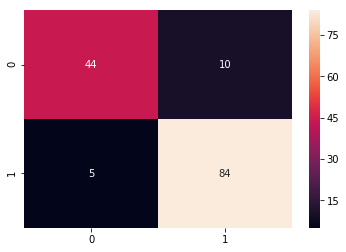

In [101]:
cm = confusion_matrix(Y_test, predictions)

sns.heatmap(cm, annot=True);